# Baby Steps into Optical Mark Recognition (OMR) with Python and OpenCV

with Abram Hindle <hindle1@ualberta.ca>

Optical mark recognition is the attempt to scan marks on a sheet of paper and convert them to useful data. Like bubbles you fill on a multiple choice exam.

OMR is not OCR. OCR is character recognition, marks are typically placed on templates that we recognize and turn into data.


In [239]:
# Juypter Notebooks are frustrating
from IPython.display import HTML
HTML('<style>{}</style>'.format(open('custom.css').read()))

In [240]:
import matplotlib.pyplot as plt
import numpy
import numpy as np
from IPython.display import display
from PIL import Image
import cv2 as cv
import sys
import matplotlib

In [241]:
%matplotlib inline

In [242]:
matplotlib.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200


# 1.0 OMR Process

1. Scan documents
1. Normalize documents
  1. Keep the size consistent
  1. Try to detect orientation and rotate to correct
  1. If you have some kind of rules or edges try to correct
  1. Consider modifying or normalizing brightness and contrast
1. Find the template (the OMR part) of the document
1. Extract template
1. Interpret marks on template
1. Output results

## 1.1 OMR Evaluation

1. Scan and normalize documents
1. Manually Label documents with correct results
1. Apply OMR process
1. Compare results:
  1. Accuracy `# correct / # total` 


# 2.0 Make a template

![Example Template](blank001.png)

Try to keep it clean. When you place it on a printout try to keep it the same size. Know your DPI ahead of time.

Also consider features that you can use for orientation.
* A rounded corner
* A cut off corner
* Asymmetrical shapes
* Corner markings
* Consistent Placement

Also consider using circles for bubbles. My students have a hard time with squares.

## 2.1 Example placement

* Don't let it touch other content -- edge detectors care about this
* Try to give it some whitespace.

![Example template in action](safe-blanks/pg_00533.pdf.png)

# 3.0 Find the template

But how?

* You can use object detectors like ORB or SIFT or other things
* You can compare pixels.

# 3.1 Template Matching

Template matching is pretty simple and pretty powerful.

https://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/template_matching/template_matching.html

# 3.1.1 Algorithm: Template Match

* Input: Template Image to find
* Input: query image to find the template in
* Output: similarity map per pixel (max similarity is likely location)
* Make new output image
* For each pixel in a query image 
  * extract a sub region the size of your template
  * calculate the distance (like sum of the difference) between the template and sub region
  * for that pixel record the distance into the new output image

# 3.1.2 Algorithm: Template Find

* Input: Template Match Output Image
* Output: location of template
* Find the location of the pixel with the least difference / most similarity
* Return that location

Think argmax of the template match.





# 3.1.3 Strengths

* Given assumptions it is very robust
* It is very fast when done right (openCV, numpy, etc.)
* It is so fast you can apply it many times

# 3.1.4 Weaknesses

* Template matching is not rotation invariant. Heavy rotation is not easy.
* Template matching is not flip or mirror invariant.
* Template matching is not scale invariant.

# 3.2 Template Find  Code

In [314]:
def flip_image_slow(img):
    w, h = img.shape[::-1]
    center = (w/2,h/2)
    M = cv.getRotationMatrix2D(center, 180, 1.0)
    imgUP = cv.warpAffine(img, M, (w, h))
    return imgUP

def find_template(input_img, template_img):
    img_gray = cv.cvtColor(input_img, cv.COLOR_BGR2GRAY)
    res = cv.matchTemplate(img_gray,template_img,cv.TM_CCOEFF_NORMED)
    print(input_img.shape,res.shape) # it makes a smaller image
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    pt = max_loc
    (h,w) = template_img.shape
    sub = img_gray[pt[1]:pt[1]+h,pt[0]:pt[0]+w]
    return (sub, pt, res)

def grayscale(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def plot_row(row,figsize=(10,5)):
    fig=plt.figure(figsize=figsize)
    n = len(row)
    for i in range(0,n):
        fig.add_subplot(1,n,1+i)
        plt.imshow(row[i])
    plt.show()

(1100, 850, 3) (825, 650)
(578, 61)


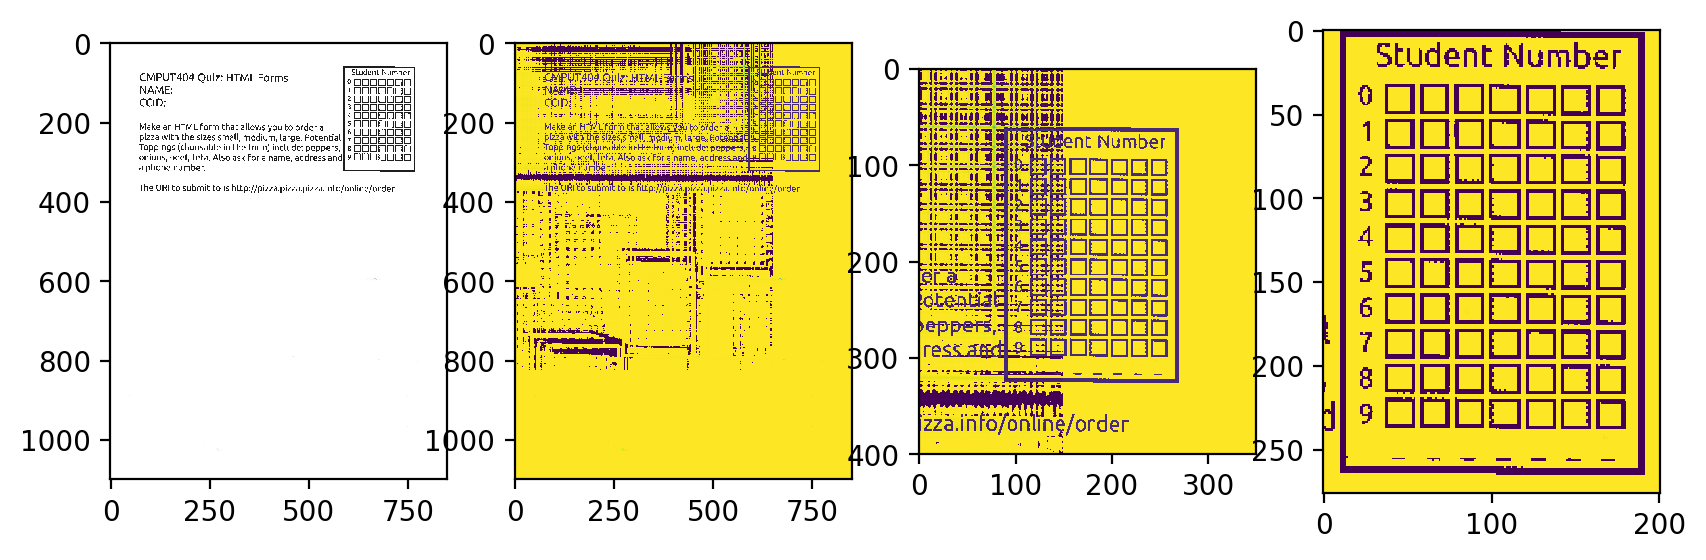

In [359]:
# Demo of template matching working

img_rgb = cv.imread("safe-blanks/pg_0053.pdf.png")
template = cv.imread('blank001.png',0)

(sub,pt,res) = find_template(img_rgb, template)

print(pt)

# yellow is max, blue is min
# fix combo
combo = grayscale(img_rgb)
combo[0:res.shape[0],0:res.shape[1]] -= (100*res).astype('uint8')
plot_row([img_rgb,combo,combo[0:400,500:],sub])


In [316]:
def extract_template_from_image(img, template):
    (sub,pt,res) = find_template(img_rgb, template)
    return sub

def extract_template_from_file(filename, template):
    img_rgb = cv.imread(filename)
    return extract_template_from_image(img_rgb, template)


# 4.0 Now to figure out the marks!

Oh wait, I can't show you what I did due to privacy laws. Dang that makes prepping for this presentation really hard. Hmmm.

Well lets generate some data instead :)

# 4.1 Sidequest: Generating training data

Augmenting data and synthetic training data is not a bad thing, it just can be inaccurate, but it gives you flexibility in the solutions you can choose.

You can use machine learning later if you can generate lots of data---even deep learning!

## 4.1.1 Synthetic Data Generation:

* Load template
* Generate a value
* Fill out template
* Save labelled example

### 4.1.1.1 Code


In [331]:
import random
N_DIGITS = 7
# I opened up Gimp and found the middle point of the digits 0 to 9
digits_mid = [40,63,82,104,124,144,166,186,206,229]
# I opened up Gimp and found the middle columns
columns_mid = [45,66,88,109,130,151,171]
box_w = box_h = 16
def make_noise(img, center, offset=0.0):
    xs = int(center[1]-box_w/2)
    xe = xs + box_w
    ys = int(center[0]-box_h/2)
    ye = ys + box_h
    img[ys:ye,xs:xe] *= (255*np.clip(
        np.tanh(
            np.random.normal(
                offset,size=(box_h,box_w)))
        ,0
        ,1)).astype('uint8')
def make_light_noise(img, center):
    make_noise(img,center,2.0)

def make_black(img, center):
    xs = int(center[1]-box_w/2)
    xe = xs + box_w
    ys = int(center[0]-box_h/2)
    ye = ys + box_h
    img[ys:ye,xs:xe] *= 0
    
def make_something(img, center):
    options = [make_noise, make_black, make_light_noise]
    random.choice(options)(img,center)
    
def label_image(img,digits):
    img = np.copy(img)
    for i in range(0,len(digits)):
        x = columns_mid[i]
        y = digits_mid[int(digits[i])]
        make_something(img, (y,x))
    return img

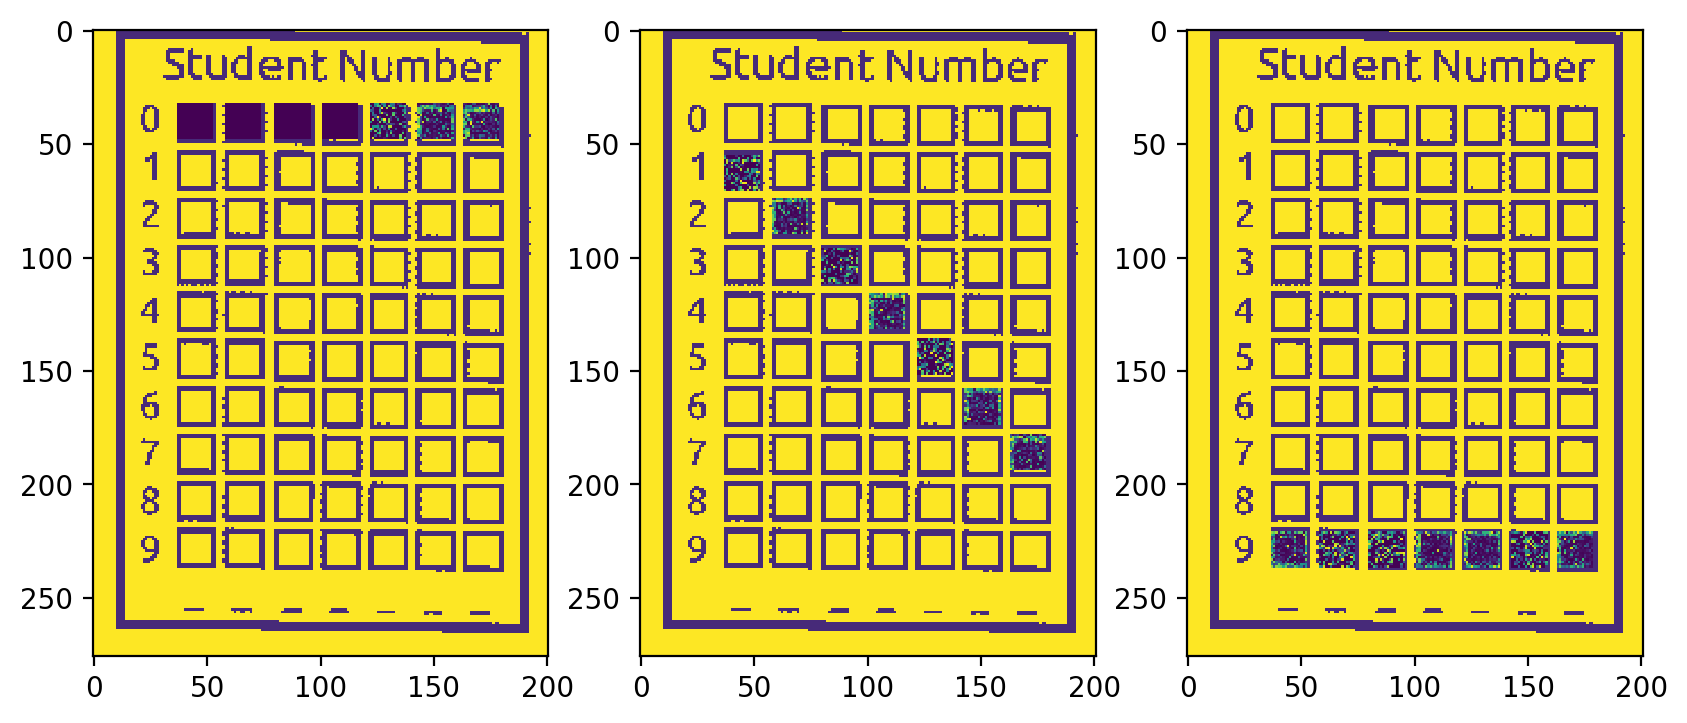

In [333]:
N_DIGITS = 7
template = cv.imread('blank001.png',0)
zerod = label_image(template,[0 for i in range(1,N_DIGITS+1)])
series = label_image(template,list(range(1,N_DIGITS+1)))
nine  = label_image(template,[9,9,9,9,9,9,9])
plot_row([zerod,series,nine])

# 4.2 Let's make a training set and evaluation set

Training set is what we can learn from, evaluation set is a hold out we evaluate on.

You usually do this manually or you engage in synthetic data generation like we have here.

In [334]:
def random_student_number(n=7):
    digits = list(range(0,10))
    return [random.choice(digits) for i in range(0,n)]

def generate_random_labelled_image(template=template):
    digits = random_student_number()
    return (digits,label_image(template, digits))

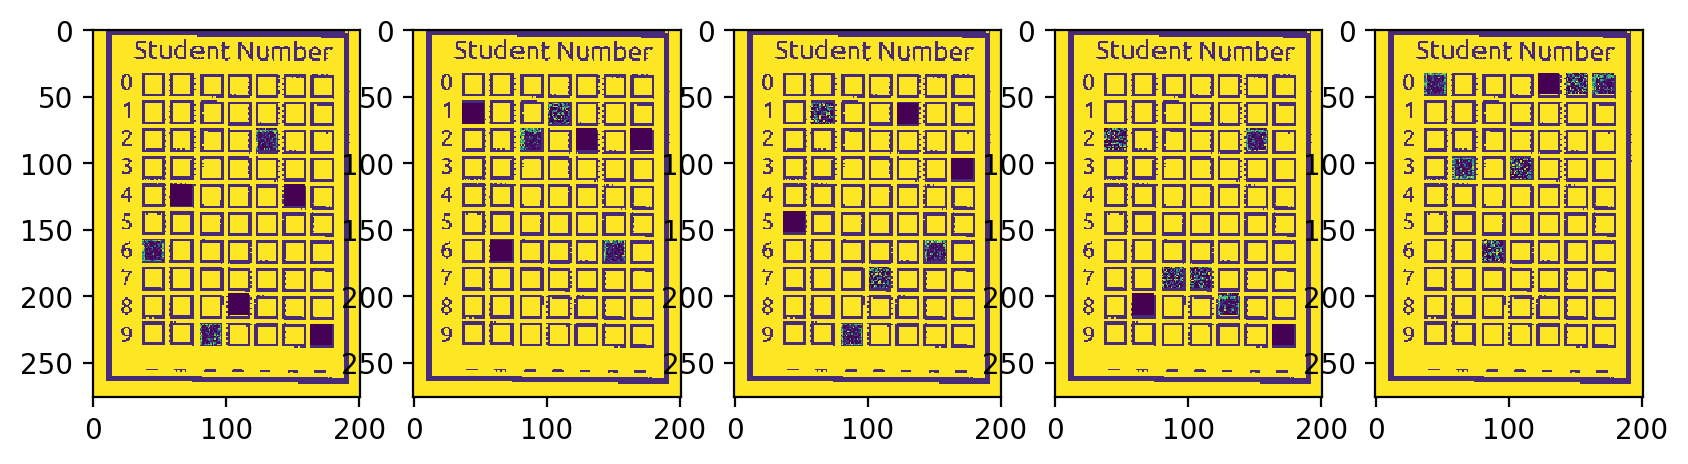

In [335]:
training_set   = [generate_random_labelled_image() for i in range(0,100)]
evaluation_set = [generate_random_labelled_image() for i in range(0,100)]

plot_row([random.choice(training_set)[1] for i in range(5)])

# 4.3 Let's label our examples!

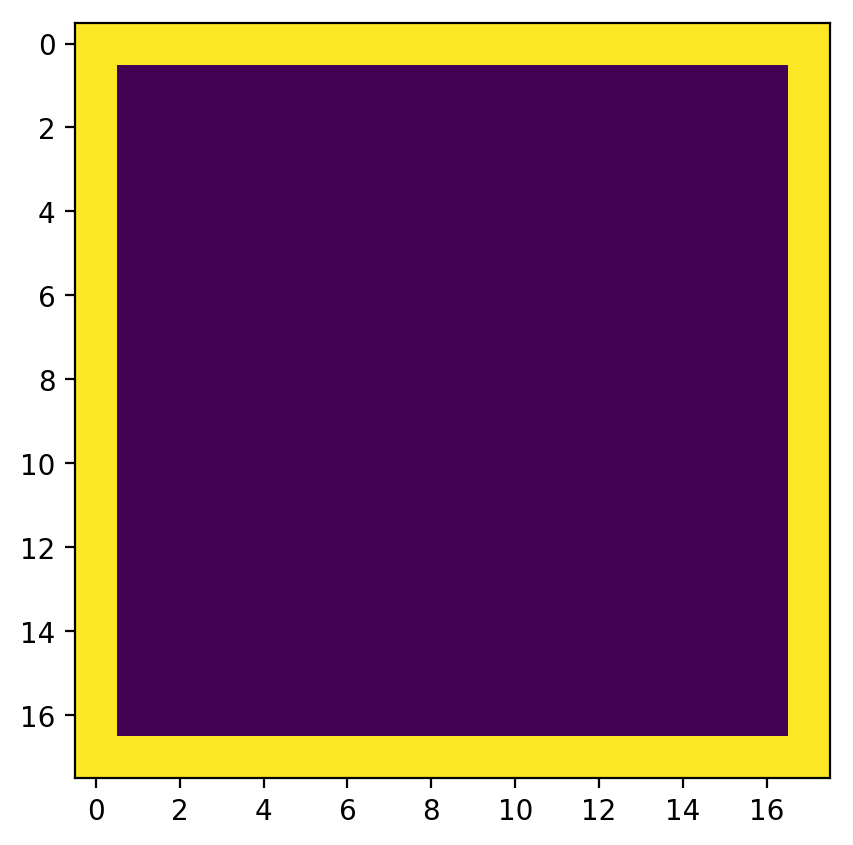

In [336]:
# First let's make a template for a filled in mark.

box_template = 255*np.ones((box_w+2,box_h+2),dtype='uint8')
make_black(box_template,(box_w/2+1,box_h/2+1))
plot_row([box_template])

# Let's choose an example.

Randomly we'll select an example to work on

In [337]:
(expected_label, img_gray) = random.choice(training_set)
img_rgb = cv.cvtColor(img_gray,cv.COLOR_GRAY2RGB)

# Now we template match against the black box

We'll get a lot of points though.

In [338]:
w, h = box_template.shape[::-1]

# use template match again to 
res = cv.matchTemplate(img_gray,box_template,cv.TM_CCOEFF_NORMED)
# sort by value
points = np.unravel_index(np.argsort(res, axis=None)[-128:], res.shape)
points

(array([157, 219, 222,  35, 157, 159,  98, 156, 159, 161, 158, 157, 136,
        160, 135, 158,  31,  96, 158, 131, 156, 134, 135,  35, 220, 157,
         33,  96, 156, 139, 158, 160, 159, 138,  95, 220, 159, 155,  97,
        159, 222, 156,  32,  30, 134, 155, 157, 157,  31, 160,  33, 159,
        138, 160, 154, 156, 156,  94, 139,  95,  34, 158, 222, 155, 222,
         35, 158,  30, 160,  34, 156,  95,  34,  97, 159,  31,  94, 158,
        157, 158, 134,  32, 158,  94, 158,  94, 155, 158,  96, 159, 157,
        138, 159, 156, 157, 156, 159,  97, 158,  31, 157, 135,  97, 138,
        134,  34,  96,  33, 156,  97,  33, 135,  96,  96,  33, 158, 158,
        135, 135, 135, 156, 157, 158,  33, 157, 158, 135, 135]),
 array([ 59, 141, 140,  35, 165, 161, 123,  61, 165, 164,  62, 161, 100,
         56,  94,  83,  36, 119,  54, 100,  58, 103, 107,  38, 143, 162,
         34, 124,  82, 102,  77,  81, 162,  99, 120, 141,  78,  56, 124,
         82, 144,  57,  38,  38,  99,  81,  77,  83,  35,  

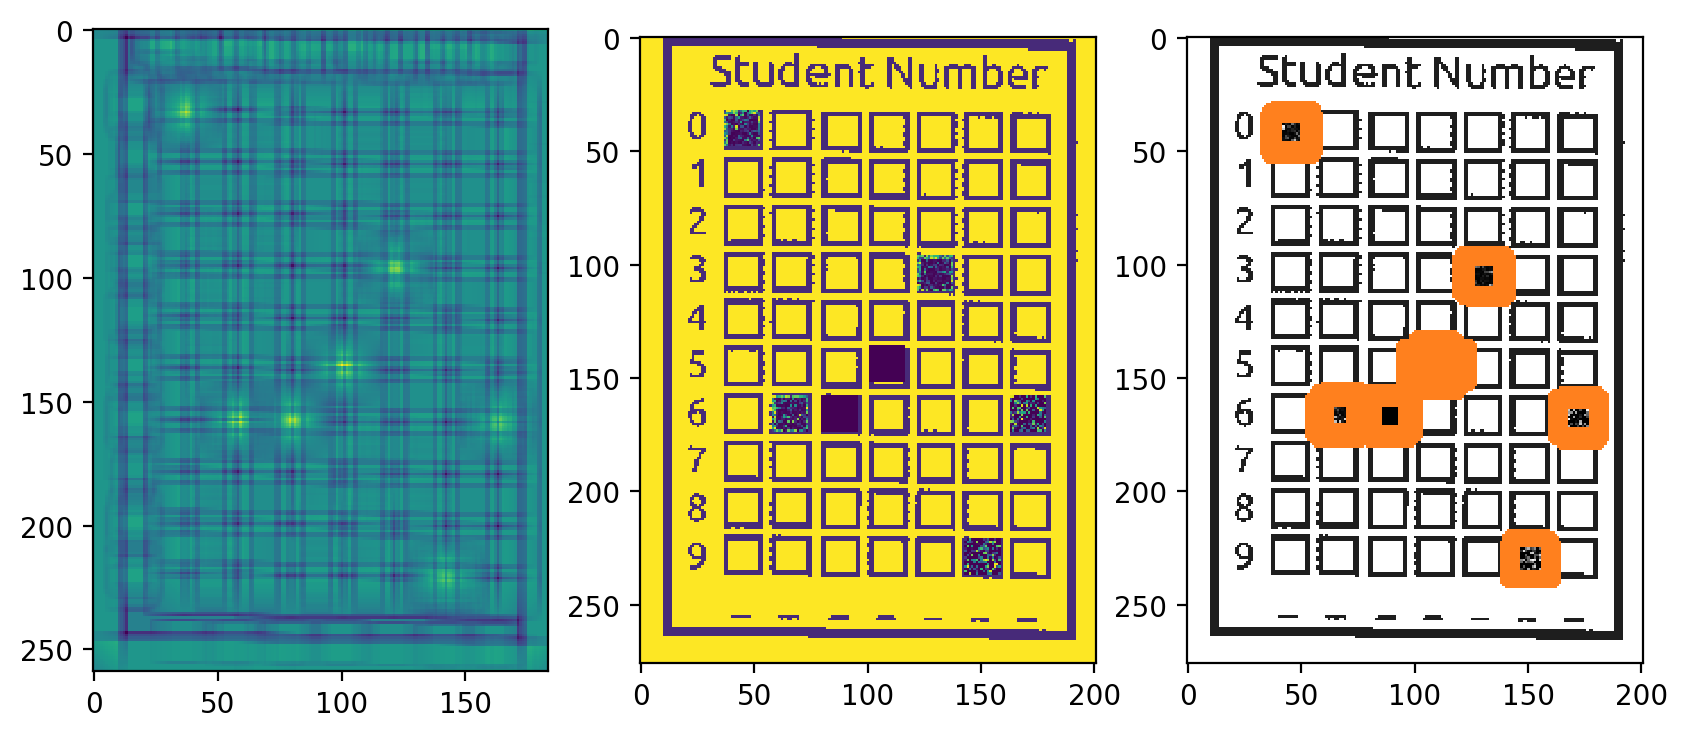

In [339]:
oloc = list(zip(*points[::-1])) 
for pt in oloc:
    # print(pt)
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (255,128,30), 3)
plot_row([res, img_gray, img_rgb])

# We have too many points in the same locations

We have deduplicate the results so we can get individual boxes.

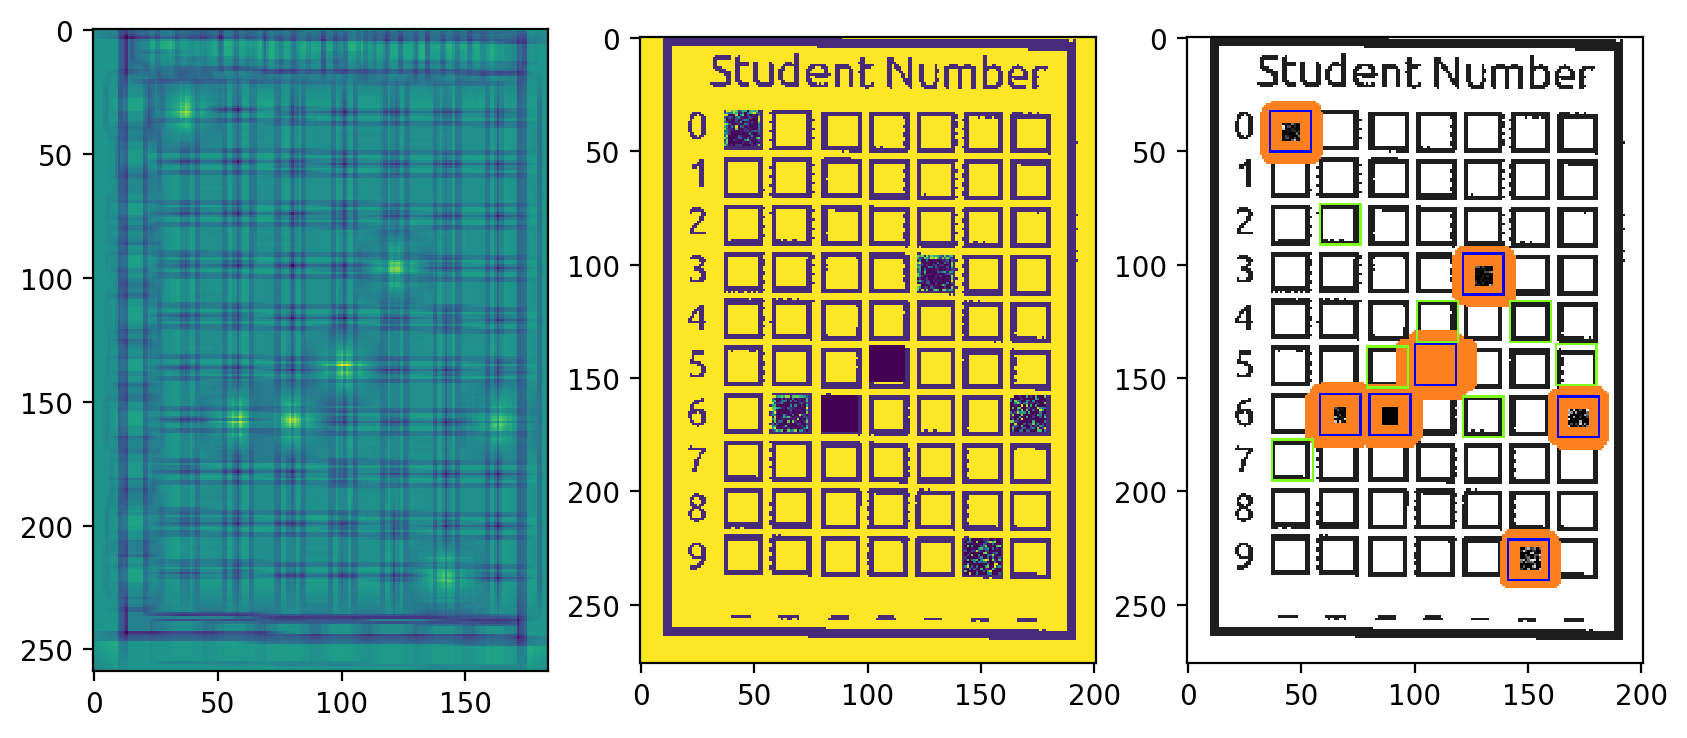

In [341]:
def similar(pt1,pt2,threshold=15):
    """ Are 2 points similar within a threshold? """
    return (pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2 < threshold**2
def avgpt(pts):
    """ What is the average point"""
    l = len(pts)
    if l == 0:
        return (0,0)
    x = 0
    y = 0
    for pt in pts:
        x += pt[0]
        y += pt[1]
    return (int(x/(1.0*l)),int(y/(1.0*l)))

def filter_similar_points(pts):
    """ Remove points that are too similar"""
    # keep earlier points
    out = list()
    # N^2 just remove dupes
    while len(pts) > 0:
        pt = pts[0]
        #print(pt)
        simpts = [npt for npt in pts if similar(pt,npt)]
        pts.pop(0)
        apt = avgpt(simpts)
        out.append(apt)
        #out.append(pt)
        pts = [npt for npt in pts if not similar(pt,npt)]
    return out

def is_white_box(pt,img=img_gray):
    """ is this just an empty box """
    avgpixel = np.sum(img[pt[1]:pt[1]+h,pt[0]:pt[0]+w])/(1.0*w*h)
    return avgpixel > 160

pts = oloc
# filter locations
newloc = filter_similar_points(list(oloc))
# filter out white boxes
newloc = [pt for pt in newloc if not is_white_box(pt)]

for pt in newloc:
    # print(pt)
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)
plot_row([res, img_gray, img_rgb])





# We can take those groups of similar points and group them together

Clustering techniques can help us group these points.

We'll use K-means since we have a good idea of K.

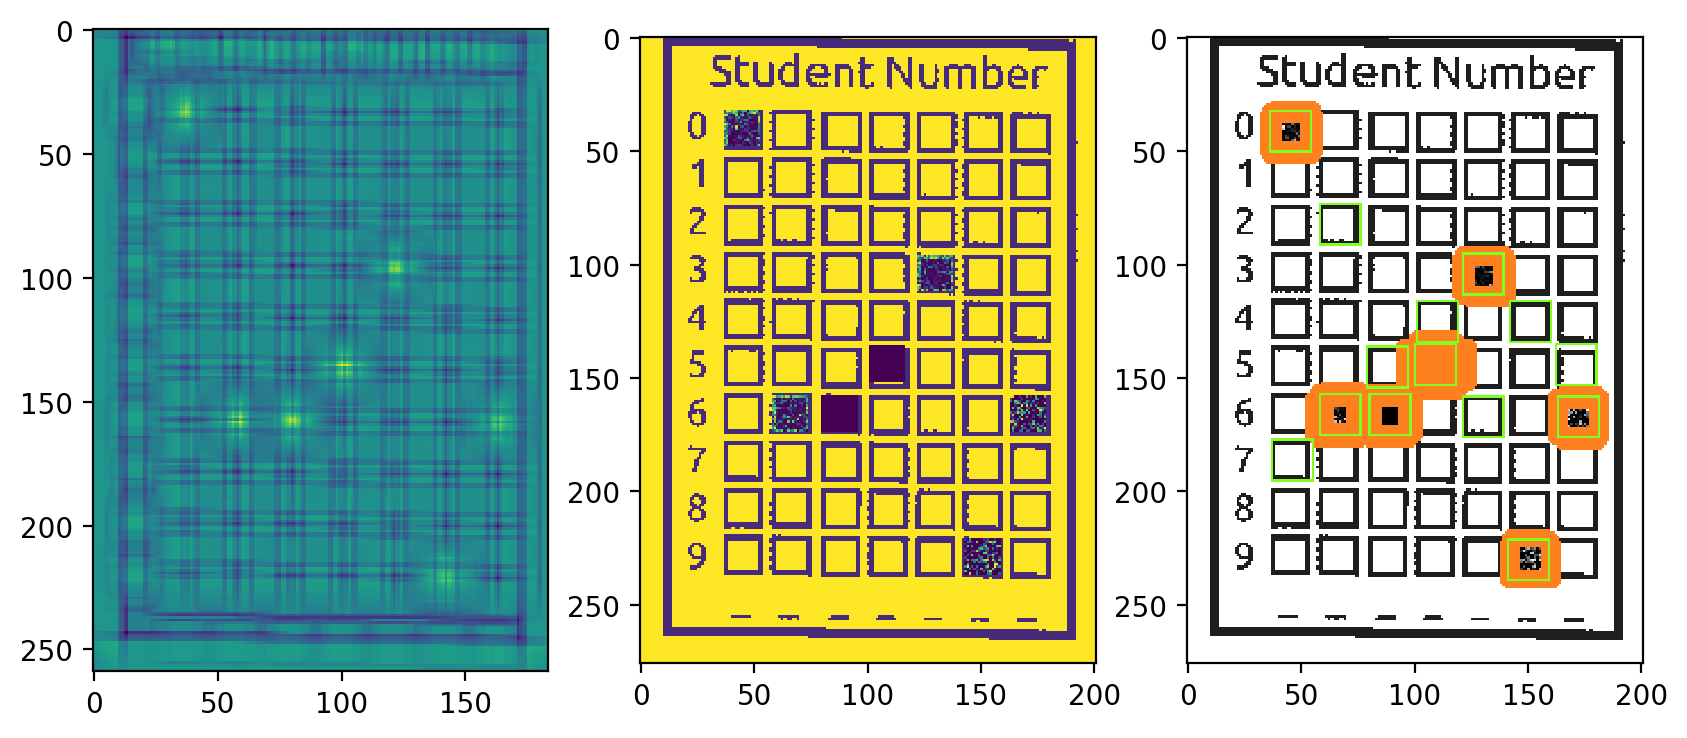

N Locations: 7 and its equal to N_DIGITS? True


In [342]:
# we want to filter the newlocations further. K-Means can help us do this

K=N_DIGITS

# What if we didn't find K points?
if len(newloc) < K:
    newloc = oloc
    # newloc = filter_similar_points(list(pts))
    newloc = [pt for pt in newloc if not is_white_box(pt)]

# OK we have at least K
if len(newloc) >= K:
    Z=np.float32(np.array(newloc))
    #find 7 centers
    
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 40, 0.01)
    ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
    center = np.int32(center)
    pts = list(map(tuple, center))
    
    newloc = pts
    
# Show the new locations

for pt in newloc:
    # print(pt)
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (128,255,30), 1)
plot_row([res, img_gray, img_rgb])

print(f"N Locations: {len(newloc)} and its equal to N_DIGITS? {len(newloc)==N_DIGITS}")


# Now we have to turn those locations into DIGITS and check if they are correct.

We'll compare centers of the locations with the centers of each digit.


0665396 [0, 6, 6, 5, 3, 9, 6] True


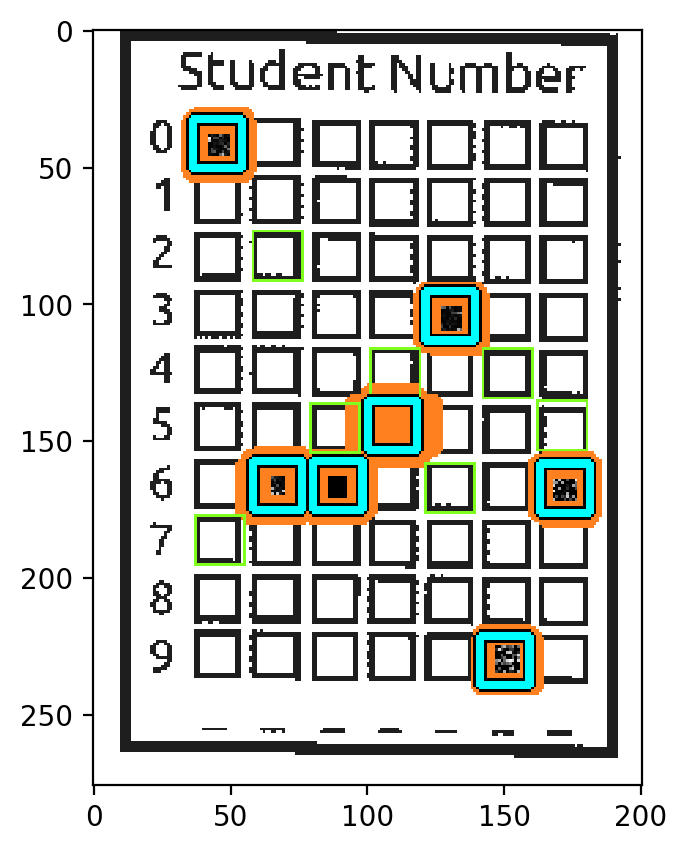

In [344]:
# classify

points = sorted(newloc,key=lambda x: x[0])
# center points
points = [(x[0]+w/2,x[1]+h/2) for x in points]
zipped_centers = list(zip(digits_mid, range(0,10)))
def closest_digit(point,h=276,templateh=276):
    my = point[1]
    ny = templateh*my/(1.0*h)
    closest = 0
    diff = templateh
    for y,d in zipped_centers:
        newdiff = abs(ny - y)
        if newdiff < diff:
            diff = newdiff
            closest = d
    return closest

# print([(p[0],p[1]) for p in points])
sid = "".join([str(closest_digit(x)) for x in points])
expected = "".join([str(x) for x in expected_label])
if sid == "":
    sid = "blank"
if len(expected_label) == 0:
    expected = "blank"
print(f"{sid} {expected_label} {sid==expected}")


for pt in newloc:
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,0), 3)
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2)

plot_row([img_rgb])    



# Success?

No, not yet. We still need to evaluate the result.


In [345]:
def similar(pt1,pt2,threshold=15):
    """ Are 2 points similar within a threshold? """
    return (pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2 < threshold**2
def avgpt(pts):
    """ What is the average point"""
    l = len(pts)
    if l == 0:
        return (0,0)
    x = 0
    y = 0
    for pt in pts:
        x += pt[0]
        y += pt[1]
    return (int(x/(1.0*l)),int(y/(1.0*l)))

def filter_similar_points(pts):
    """ Remove points that are too similar"""
    # keep earlier points
    out = list()
    # N^2 just remove dupes
    while len(pts) > 0:
        pt = pts[0]
        #print(pt)
        simpts = [npt for npt in pts if similar(pt,npt)]
        pts.pop(0)
        apt = avgpt(simpts)
        out.append(apt)
        #out.append(pt)
        pts = [npt for npt in pts if not similar(pt,npt)]
    return out

def is_white_box(pt,img=img_gray):
    """ is this just an empty box """
    avgpixel = np.sum(img[pt[1]:pt[1]+h,pt[0]:pt[0]+w])/(1.0*w*h)
    return avgpixel > 160

def match_points(img_gray, box_template):
    """ find matching points in the input image """
    res = cv.matchTemplate(img_gray,box_template,cv.TM_CCOEFF_NORMED)
    # sort by value
    points = np.unravel_index(np.argsort(res, axis=None)[-128:], res.shape)
    oloc = list(zip(*points[::-1]))
    return oloc

def plot_points_on_img(img, points, colour=(255,128,30),width=3):
    """ Plot points on an image """
    for pt in points:
        cv.rectangle(img, pt, (pt[0] + w, pt[1] + h), colour, width)
    return img

def filter_points(points,img_gray=img_gray):
    """ Take possible locations and widdle them down """
    # filter locations
    newloc = filter_similar_points(list(points))
    # filter out white boxes
    newloc = [pt for pt in newloc if not is_white_box(pt,img=img_gray)]
    K=N_DIGITS
    # What if we didn't find K points?
    if len(newloc) >= K:
        Z=np.float32(np.array(newloc))
        #find 7 centers    
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 40, 0.01)
        ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
        center = np.int32(center)
        pts = list(map(tuple, center))
        newloc = pts
    return newloc

def closest_digit(point,h=276,templateh=276):
    ''' try to find the closest digit '''
    my = point[1]
    ny = templateh*my/(1.0*h)
    closest = 0
    diff = templateh
    for y,d in zipped_centers:
        newdiff = abs(ny - y)
        if newdiff < diff:
            diff = newdiff
            closest = d
    return closest

def points_to_digits(points):
    ''' convert a point tuple to a digit '''
    points = sorted(points,key=lambda x: x[0])
    # center points
    points = [(x[0]+w/2,x[1]+h/2) for x in points]
    zipped_centers = list(zip(digits_mid, range(0,10)))
    sid = "".join([str(closest_digit(x)) for x in points])
    return sid


def classify_image(img_gray, box_template=box_template,plot=False):
    """ Take an image and classify it as digits """
    # find matching points
    points = match_points(img_gray, box_template)
    new_points = filter_points(points,img_gray)
    sid = points_to_digits(new_points)
    if (plot):
        img_rgb = cv.cvtColor(img_gray,cv.COLOR_GRAY2RGB)
        img1 = plot_points_on_img(np.copy(img_rgb),points,colour=(255,255,0),width=2)
        img2 = plot_points_on_img(np.copy(img1),new_points,colour=(0,0,0),width=3)
        img2 = plot_points_on_img(img2,new_points,colour=(60,180,255),width=2)
        plot_row([img_rgb,img1,img2])
    return sid
    
def accuracy(in_out_tuples):
    return sum([1*(x[0]==x[1]) for x in in_out_tuples])/len(in_out_tuples)

# 4.4 Now we're going to evaluate on the evaluation set.

We're going to iterate through each example, classify it and calculate the accuracy of the technique.

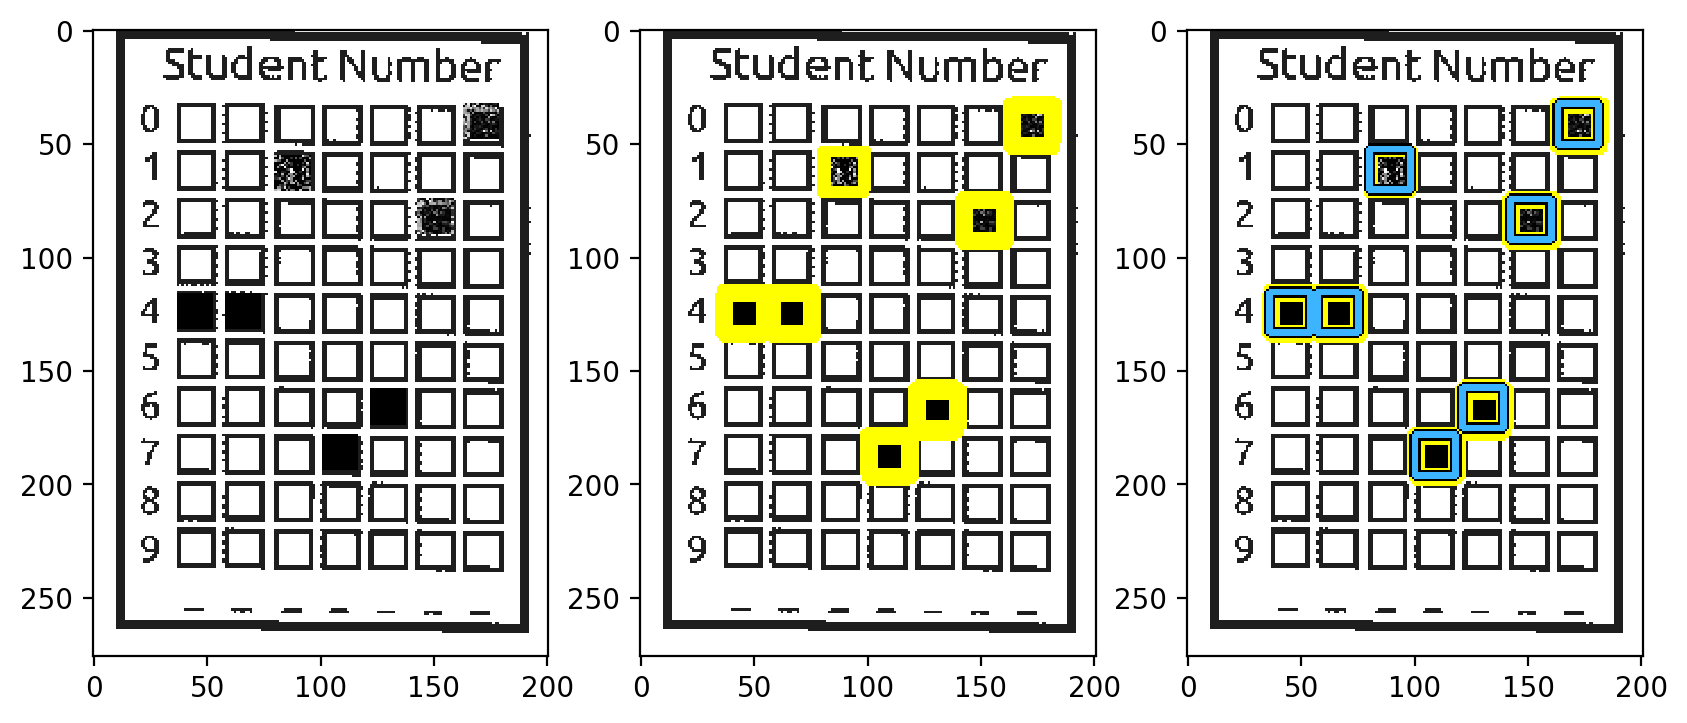

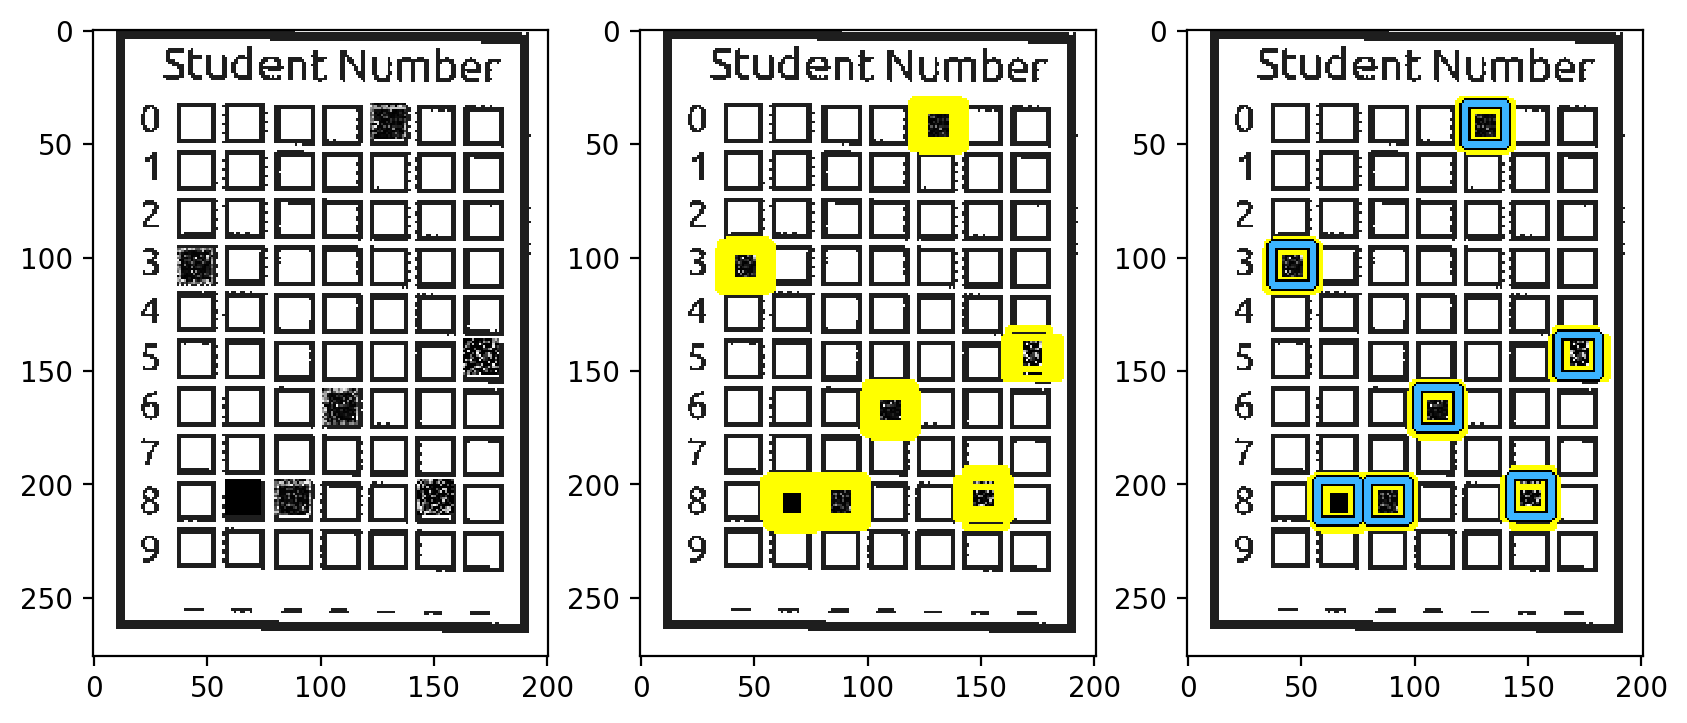

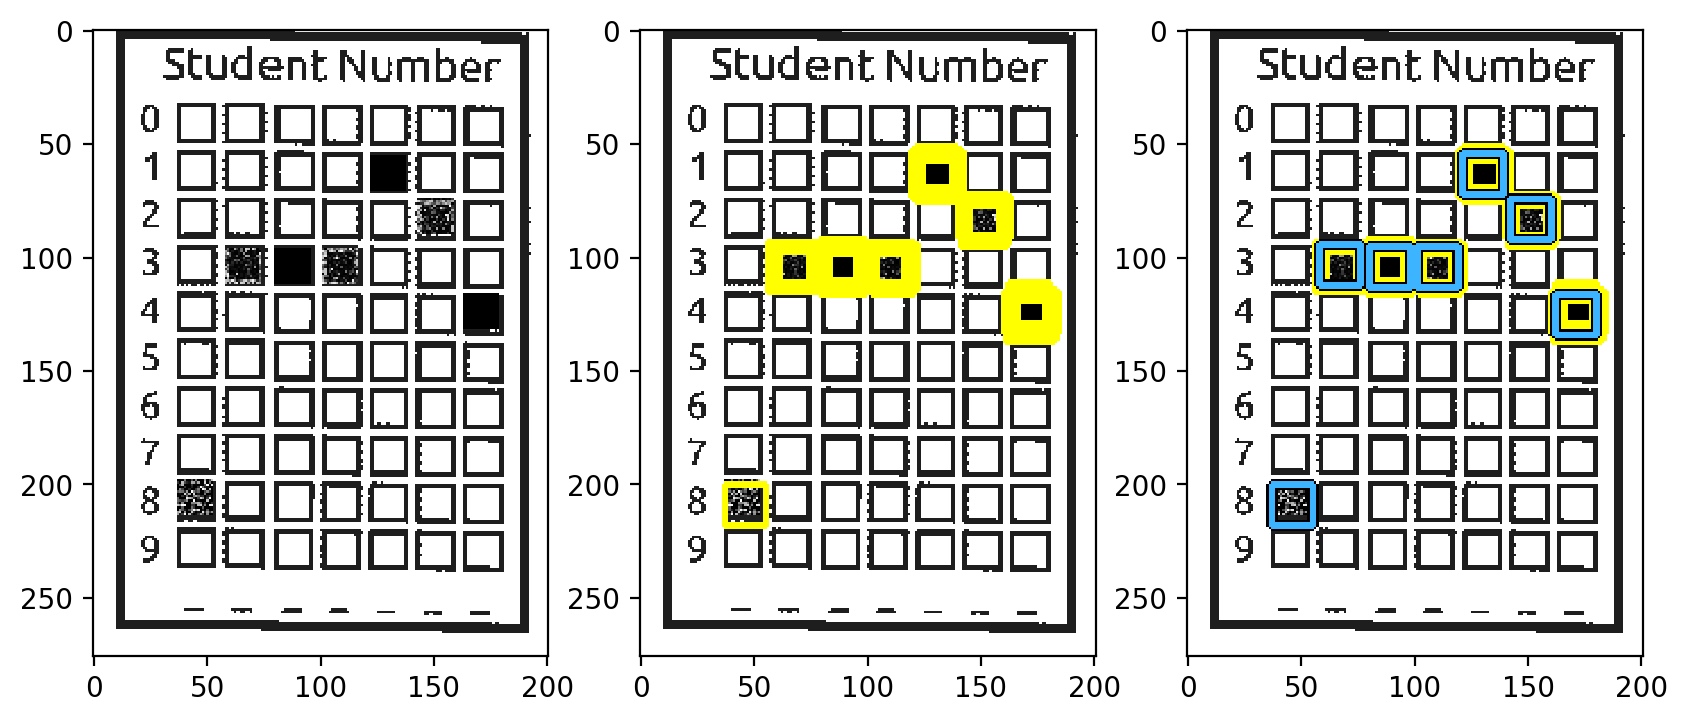

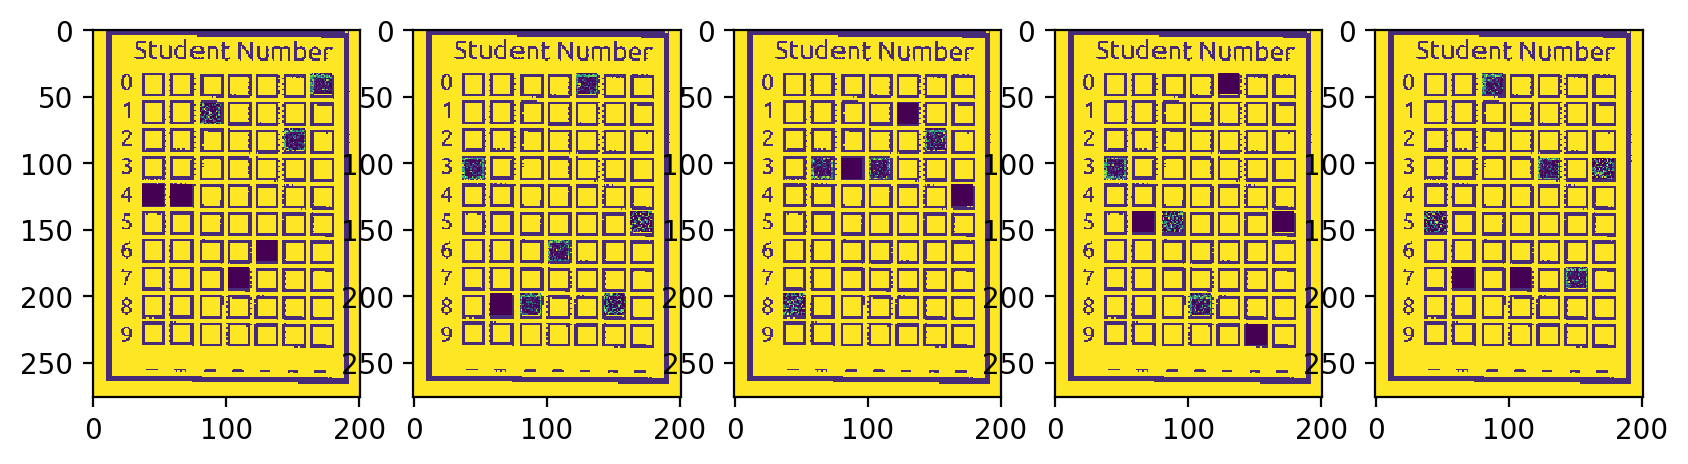

Accuracy: 1.0
Accuracy: 1.0


In [346]:
for i in range(3):
    classify_image(evaluation_set[i][1],plot=True)

res = [("".join([str(x) for x in pair[0]]),classify_image(pair[1])) for pair in evaluation_set]
plot_row([pair[1] for pair in evaluation_set[0:5]])
print("Accuracy: %s" % accuracy(res))
# plot the failures
for i in range(len(res)):
    if res[i][0] != res[i][1]:
        classify_image(evaluation_set[i][1],plot=True)
print("Accuracy: %s" % accuracy(res))

# 4.4.2 This is artificial so I don't really trust the results

Also this is ignoring the inaccuracy of the first step of finding the template in an example image.

# 4.4.3 We're going to add rotation and noise to confuse it a bit more

This will allow us to understand what abuse our system can handle.

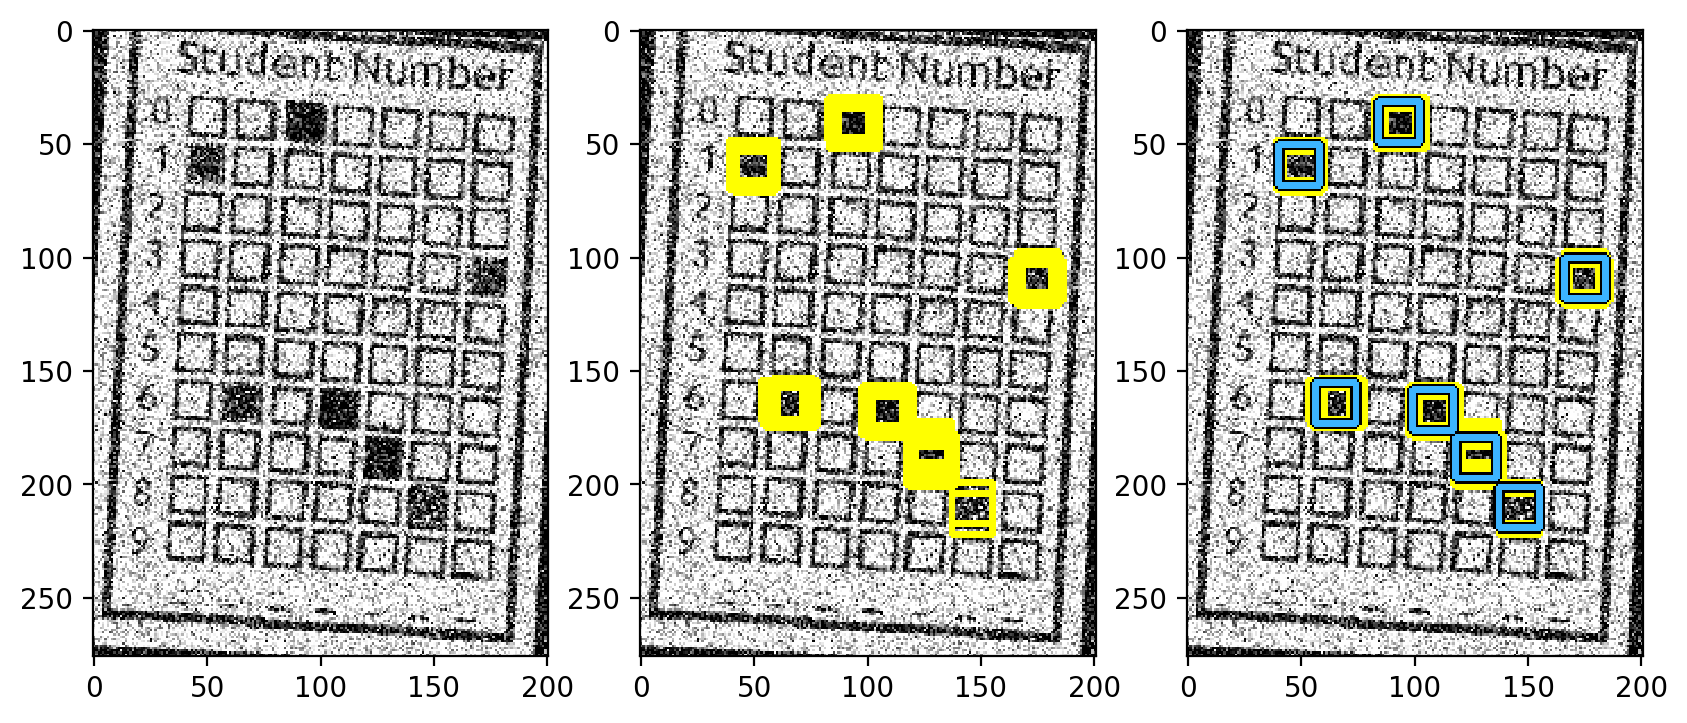

[1, 6, 0, 6, 7, 8, 3] 1606783


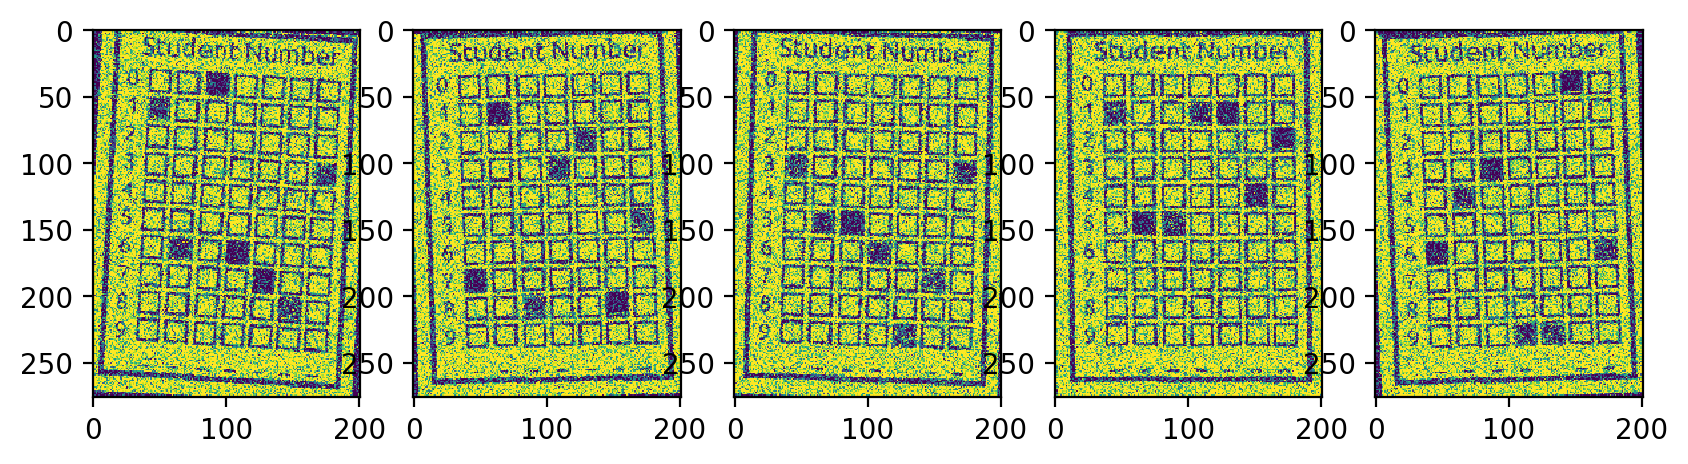

Accuracy: 0.93


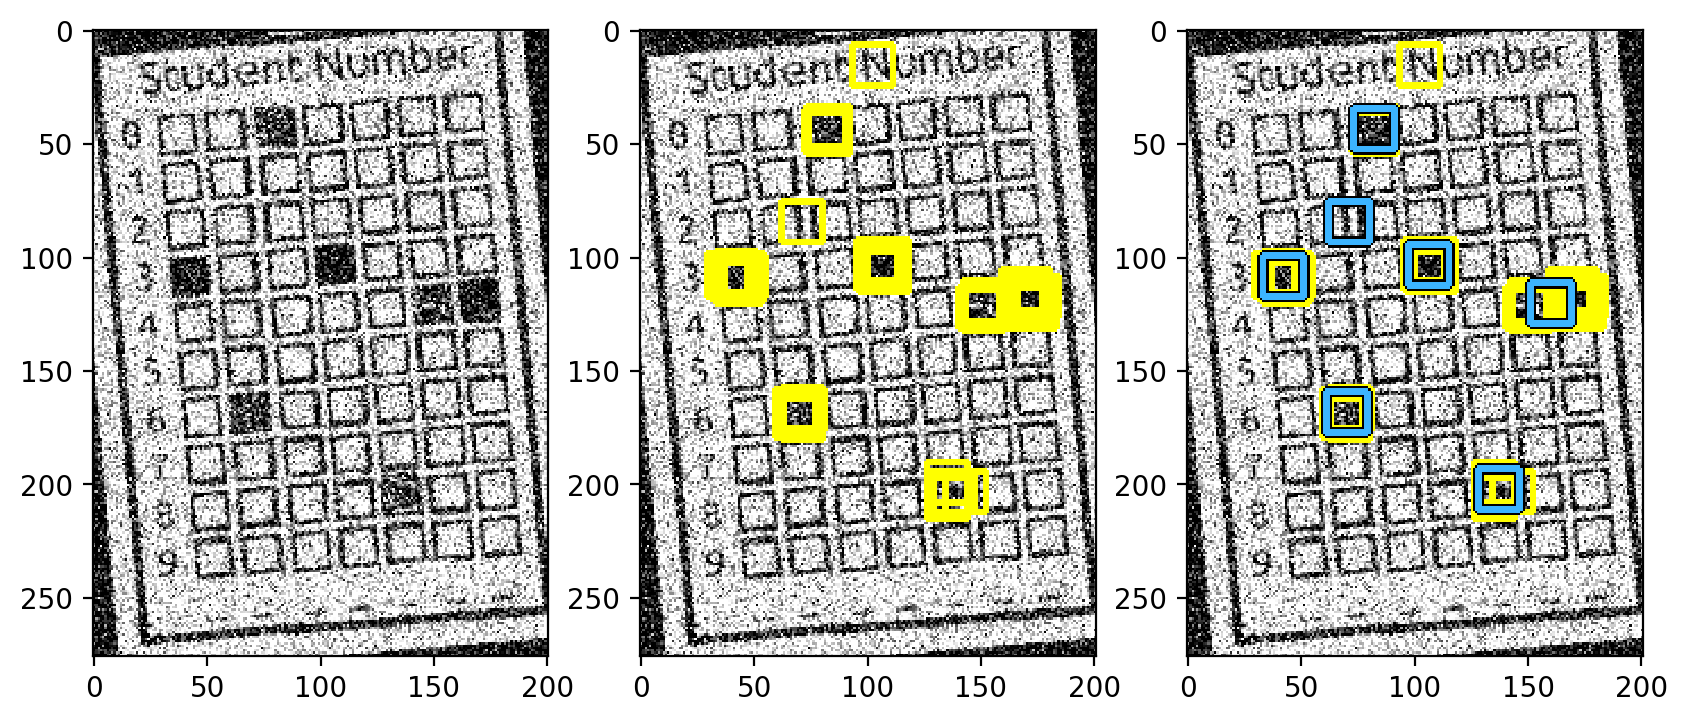

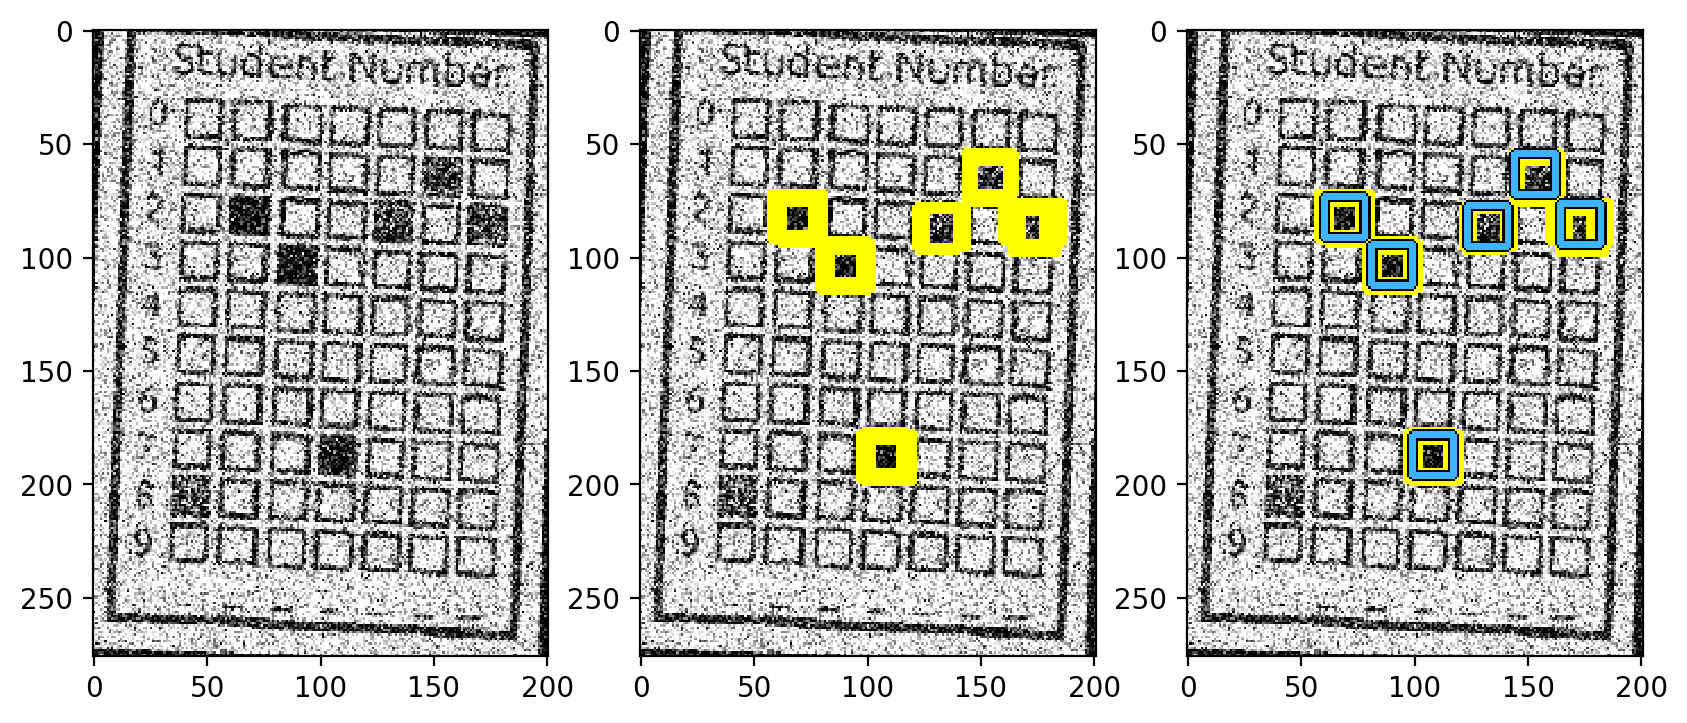

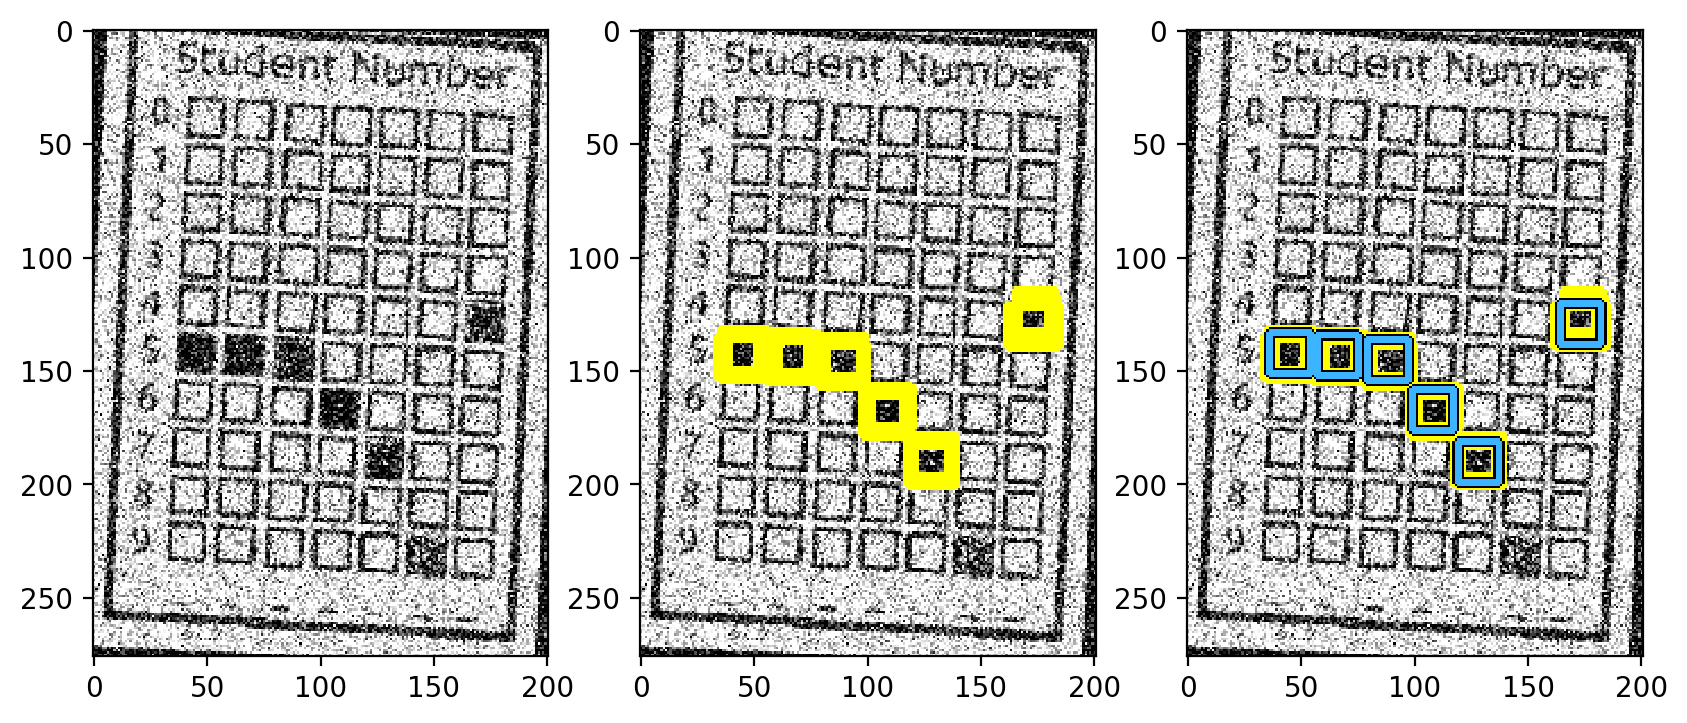

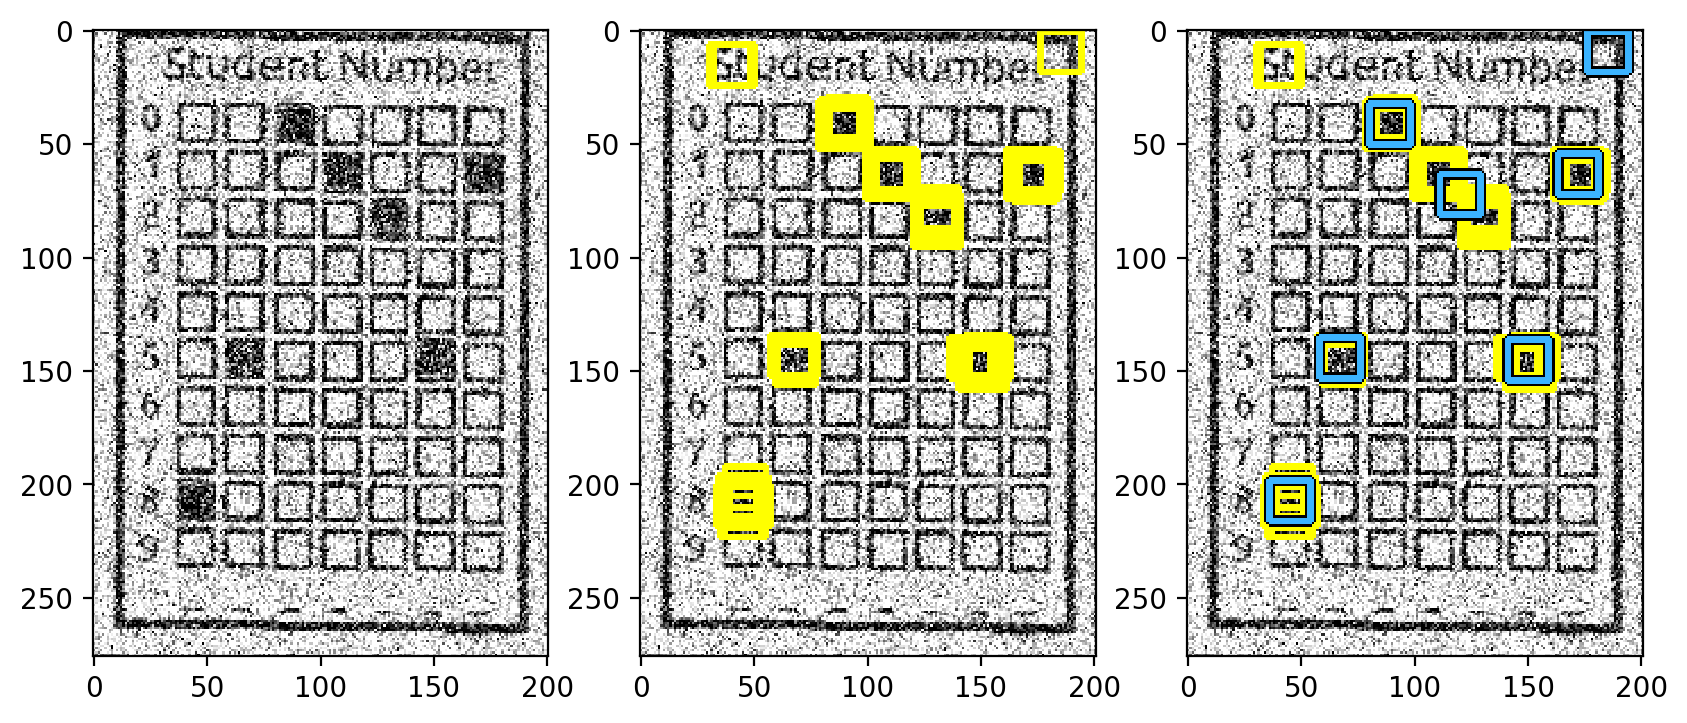

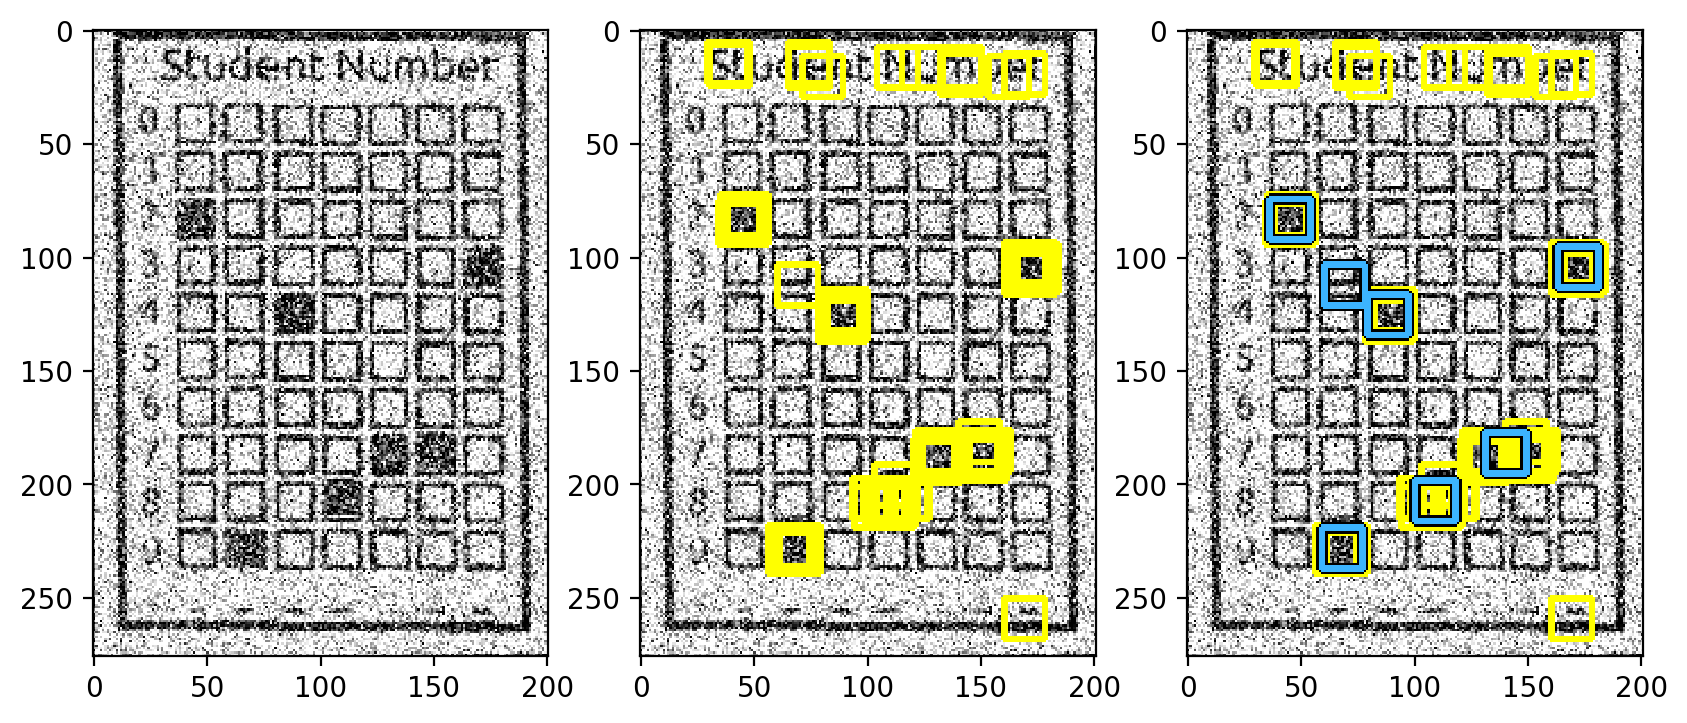

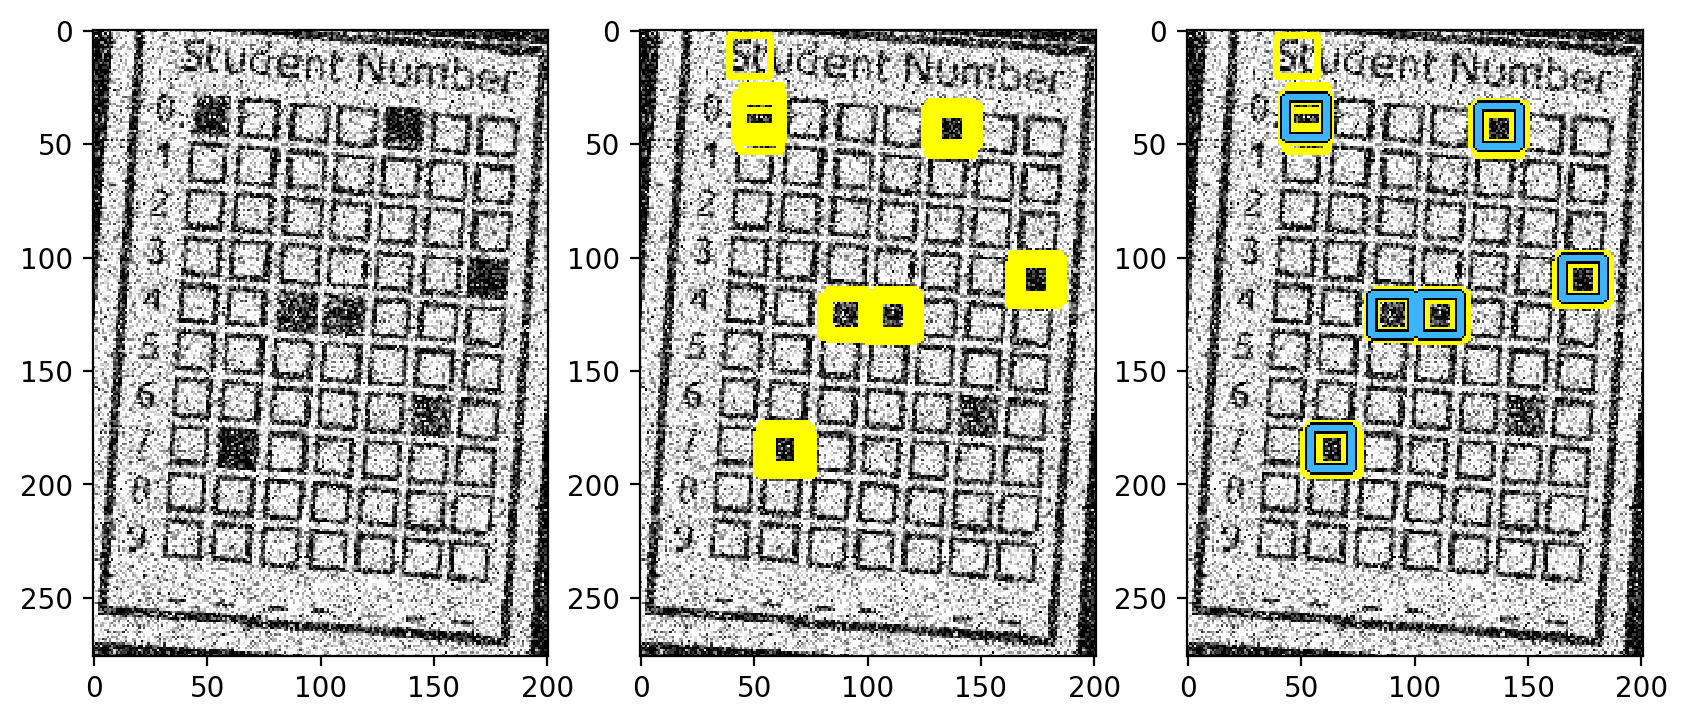

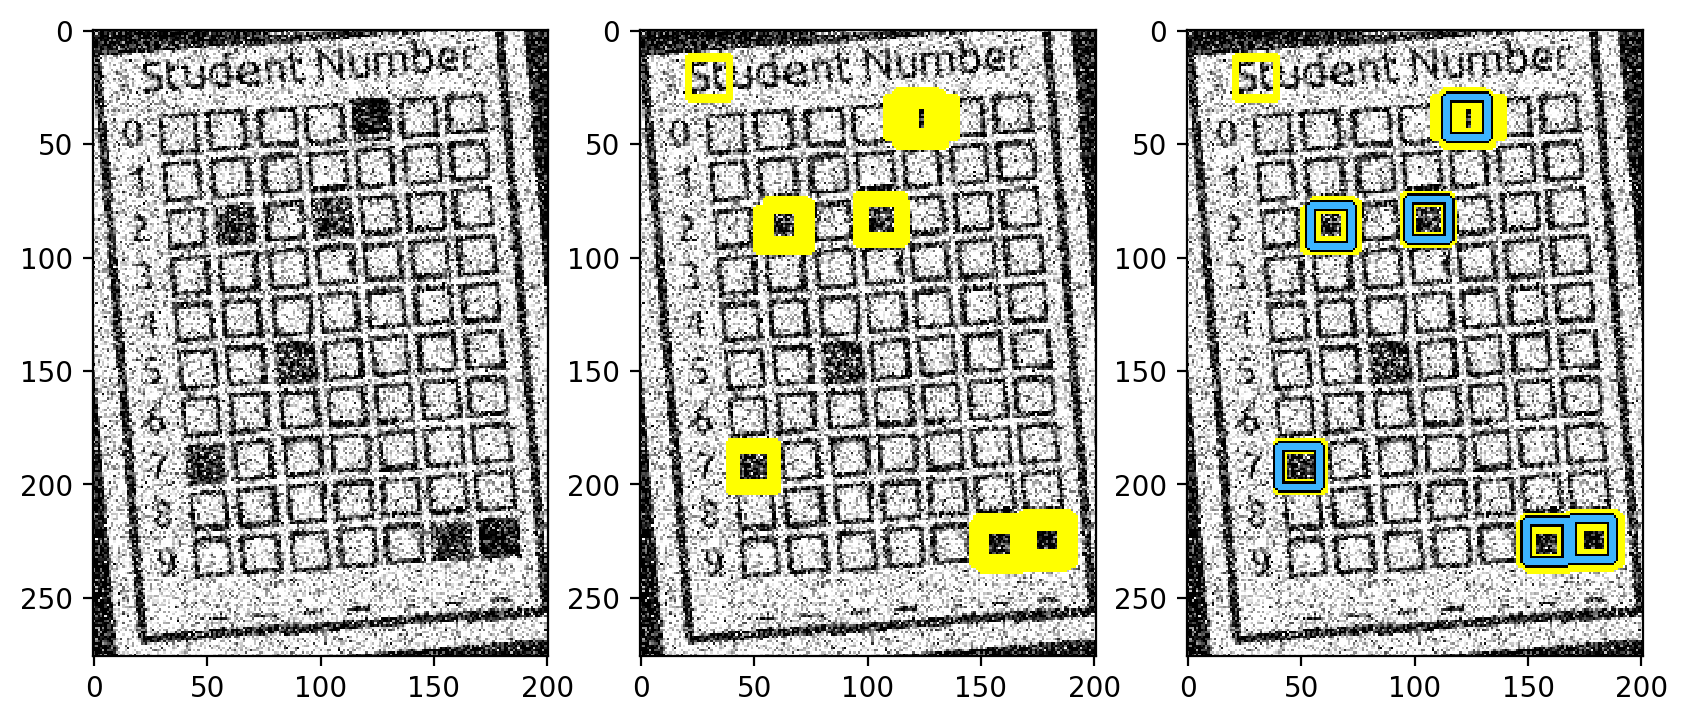

Accuracy: 0.93


In [347]:
def rotate_image(img,deg=180):
    w, h = img.shape[::-1]
    center = (w/2,h/2)
    M = cv.getRotationMatrix2D(center, deg, 1.0)
    imgUP = cv.warpAffine(img, M, (w, h))
    return imgUP

inputs = list(evaluation_set)
random.shuffle(inputs)
ROTATE_MAX=5.0
NOISE=90
# rotate them
rotated_eval_set = [(img[0],rotate_image(img[1],random.random() * 2*ROTATE_MAX - ROTATE_MAX)) for img in inputs]
# noise em up
noise_eval_set = [(img[0],np.clip(img[1] + np.random.normal(0,NOISE,size=img[1].shape),0,255).astype('uint8')) for img in rotated_eval_set]
eval_set = noise_eval_set
# classify em
res2 = [("".join([str(x) for x in pair[0]]),classify_image(pair[1])) for pair in eval_set]
print(eval_set[0][0],classify_image(eval_set[0][1],plot=True))
plot_row([pair[1] for pair in eval_set[0:5]])
print("Accuracy: %s" % accuracy(res2))
# plot the failures
for i in range(len(res2)):
    if res2[i][0] != res2[i][1]:
        classify_image(eval_set[i][1],plot=True)
print("Accuracy: %s" % accuracy(res2))


# 5.0 Tips for improving performance

* If you know the names and numbers you are looking for ahead of time limit the outputs to those. E.g. you know the student numbers in your class.
* For data augmentation you should apply transforms you will see when you scan documents.
  * mild rotation
  * noise
  * scanner noise
  * coffee stains
  * creases
* If you can generate the answer you can generate the answer and compare it to your classification result.

# 6.0 Conclusion

* Bitmap based template matching is a fast and repeatable solution for OMR tasks.
* OpenCV provides good template match code
* The result of your work is your ability to find the template multiplied by the probability of reading it correctly
  * `p(success) = p(find) * p(read)`
* Preprocessing will likely give you a lot more performance than later processing.
* K-means clustering can help you deduplicate the results of template matching.

# 7.0 References

* Template Matching in OpenCV https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html
* Multiscale template matching https://www.pyimagesearch.com/2015/01/26/multi-scale-template-matching-using-python-opencv/
* ORB Tutorial OpenCV https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html
* Image alignment in OpenCV https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

* https://github.com/abramhindle/python-omr-talk/blob/master/Python-OMR-Talk.ipynb

# Copyright

(c) 2020 Abram Hindle, Open Computer Vision Project

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

    Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
    Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
    Neither the names of the copyright holders nor the names of the contributors may be used to endorse or promote products derived from this software without specific prior written permission.

This software is provided by the copyright holders and contributors “as is” and any express or implied warranties, including, but not limited to, the implied warranties of merchantability and fitness for a particular purpose are disclaimed. In no event shall copyright holders or contributors be liable for any direct, indirect, incidental, special, exemplary, or consequential damages (including, but not limited to, procurement of substitute goods or services; loss of use, data, or profits; or business interruption) however caused and on any theory of liability, whether in contract, strict liability, or tort (including negligence or otherwise) arising in any way out of the use of this software, even if advised of the possibility of such damage.